### Imports

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random

DATASET_PATH = '../data/train/'
VAL_DATASET_PATH = '../data/val/'
TEST_DATASET_PATH = '../data/test/'

### Read augmented images from folder

In [2]:
def read_files(paths):
    rawx=[]
    rawy=[]
    for p in paths:
        for root, dirs, files in os.walk(p):
            for file in files:
                img = cv2.imread(os.path.join(root,file),cv2.IMREAD_GRAYSCALE)
                rawx.append(img)
                rawy.append(int(file.split('_')[1]))
    h, w = rawx[0].shape
    
    xy = list(zip(rawx,rawy))
    random.shuffle(xy)
    rawx,rawy = zip(*xy)
    rawx = np.asarray(rawx)
    rawy = np.asarray(rawy)
    rawx = rawx.reshape(len(rawx),h*w)
    return rawx, rawy, h, w

In [3]:
xtrain, ytrain, im_h, im_w = read_files([DATASET_PATH,VAL_DATASET_PATH])
num_classes = len(np.unique(ytrain))

In [4]:
np.unique(ytrain, return_counts=True)

(array([0, 1, 2, 3, 4, 5]),
 array([1150, 1150, 1150, 1150, 1150, 1150], dtype=int64))

### Read test images from originals_test folder

In [5]:
xtest, ytest, im_h, im_w = read_files([TEST_DATASET_PATH])

### Check how the images looks like

In [6]:
def plot_6_images(xt,yt):
    
    idxs = [ random.randint(0,len(xt)-1) for i in range(0,6)]
    plt.figure(figsize=(10,5))
    for i in range(6):
        plt.subplot(2,3,i+1)
        plt.imshow(xt[idxs[i]].reshape(im_w,im_h),cmap='gray')
        plt.title('y={}'.format(yt[idxs[i]]))
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()  

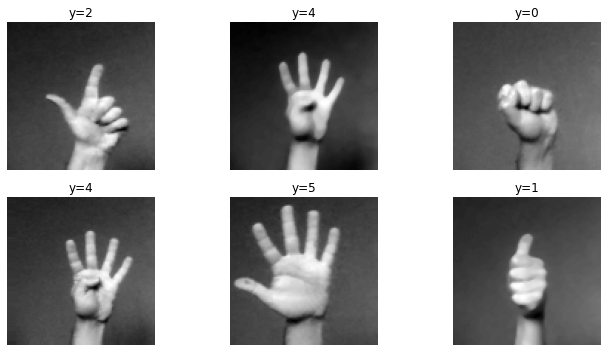

In [7]:
plot_6_images(xtrain,ytrain)

### Images are 100*100, perform PCA to reduce dimension perserving most of the variance

In [8]:
from sklearn.decomposition import PCA
pca = PCA(n_components=0.99)
%time X_reduced = pca.fit_transform(xtrain)

Wall time: 3min 32s


In [9]:
print('dimension reduction from %d to %d after PCA preserving 99%% of variance' % (xtrain.shape[1],pca.n_components_))

dimension reduction from 10000 to 800 after PCA preserving 99% of variance


### Check how the images look like after PCA

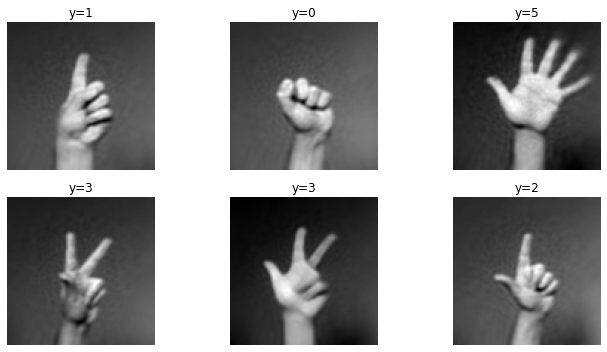

In [10]:
images = pca.inverse_transform(X_reduced)
plot_6_images(images,ytrain)

### Train different classifiers using default parameters

In [11]:
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

classifs = [
           SGDClassifier(), 
           KNeighborsClassifier(),
           DecisionTreeClassifier(),
           SVC(),
           RandomForestClassifier(),
           ]

classif_names=[
               'SGD\t\t',
               'KNN\t\t', 
               'DecisionTree\t', 
               'SVC\t\t',
               'RandomForest\t',
               ]

for name, clf in zip(classif_names, classifs):
    %time score = cross_val_score(clf, X_reduced, ytrain, cv=3, scoring="accuracy")
    print("%s : %s Score :" % (name,score), " Worst: %.4f" % score.min())

Wall time: 13.7 s
SGD		 : [0.69869565 0.69826087 0.67869565] Score :  Worst: 0.6787
Wall time: 34.5 s
KNN		 : [0.88782609 0.88173913 0.88956522] Score :  Worst: 0.8817
Wall time: 9.42 s
DecisionTree	 : [0.61695652 0.60347826 0.63826087] Score :  Worst: 0.6035
Wall time: 52.5 s
SVC		 : [0.9526087  0.95       0.95826087] Score :  Worst: 0.9500
Wall time: 26.2 s
RandomForest	 : [0.79173913 0.78695652 0.8126087 ] Score :  Worst: 0.7870


### KNN looks promising, finetune it using gridsearch 

In [19]:
from sklearn.model_selection import GridSearchCV

clf = KNeighborsClassifier(n_jobs=-1)

param_grid = [
    {
        'n_neighbors':[3,5,10],
        'p':[1,2],
    }
]

grid_search = GridSearchCV(clf,param_grid,cv=3,return_train_score=True,verbose=1)
%time grid_search.fit(X_reduced,ytrain);

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:  3.1min finished


Wall time: 3min 6s


GridSearchCV(cv=3, error_score=nan,
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=-1,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='deprecated', n_jobs=None,
             param_grid=[{'n_neighbors': [3, 5, 10], 'p': [1, 2]}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring=None, verbose=1)

In [20]:
print(grid_search.best_params_)
print(grid_search.best_score_)

{'n_neighbors': 3, 'p': 2}
0.8978260869565218


### Check accuracy on test dataset

In [21]:
from sklearn.model_selection import cross_val_predict

Xtest_reduced = pca.transform(xtest)
ytest_pred = cross_val_predict(grid_search.best_estimator_,Xtest_reduced,ytest,cv=3)
score = grid_search.best_estimator_.score(Xtest_reduced, ytest)*100

print("Model score: %.2f%% on test dataset (%d obs)" % (score,len(ytest)))

Model score: 84.50% on test dataset (1200 obs)


### Check confusion matrix

In [22]:
import pandas as pd

pd.crosstab(ytest, ytest_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,0,1,2,3,4,5,All
True,,,,,,,
0,188,6,5,1,0,0,200
1,16,148,28,7,1,0,200
2,4,9,178,9,0,0,200
3,4,7,31,155,3,0,200
4,2,5,18,10,155,10,200
5,0,4,11,11,19,155,200
All,214,179,271,193,178,165,1200


### Showing on a graph only differences (relative values) 

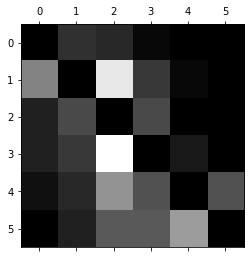

In [23]:
from sklearn.metrics import confusion_matrix

confmatr = confusion_matrix(ytest, ytest_pred)
row_sums = confmatr.sum(axis=1,keepdims=True)
norm_conf_matr = confmatr / row_sums
np.fill_diagonal(norm_conf_matr,0)
plt.matshow(norm_conf_matr,cmap=plt.cm.gray);

### Save model. (PCA has to be saved also to apply same transformation for future predictions)

In [24]:
import pickle

filename = '../models/model_classic.sav'
pickle.dump(grid_search.best_estimator_, open(filename, 'wb'))

filename = '../models/model_classic_pca.sav'
pickle.dump(pca, open(filename, 'wb'))

### Try our model on a never seen before picture (original one)

In [25]:
def plot_6_images_test(xt,yt,yp):
    
    idxs = [ random.randint(0,len(xt)-1) for i in range(0,6)]
    plt.figure(figsize=(10,5))
    for i in range(6):
        plt.subplot(2,3,i+1)
        plt.imshow(xt[idxs[i]].reshape(im_w,im_h),cmap='gray')
        if yt[idxs[i]]==yp[idxs[i]]:
          c = 'green'
        else:
          c = 'red'
        plt.title('y=%d / pred=%d' % (yt[idxs[i]],yp[idxs[i]]),color=c)
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()  

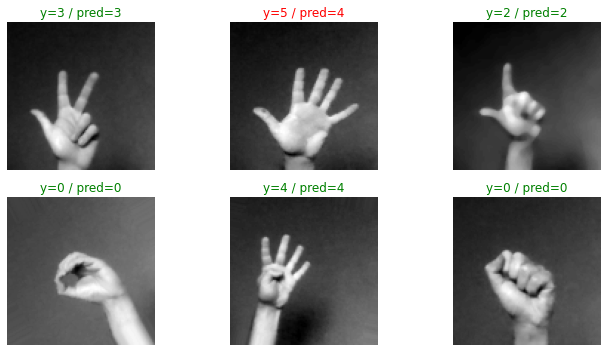

In [26]:
plot_6_images_test(xtest,ytest,ytest_pred)